## Prepare `TECjhr/sub.h5` from JPL high resolution GIM and topside TEC

In [2]:
%matplotlib inline
import os
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy.simulation import iono
from mintpy import iono_tec
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]

### Dataset: Chile Sen asc T149

incidence angle on the ground     min/max: 30.0/46.1 deg
incidence angle on the ionosphere min/max: 27.9/42.3 deg
center lat/lon  on the ground    : -21.0438/-68.4108 deg
center lat/lon  on the ionosphere: -21.7329/-71.5353 deg


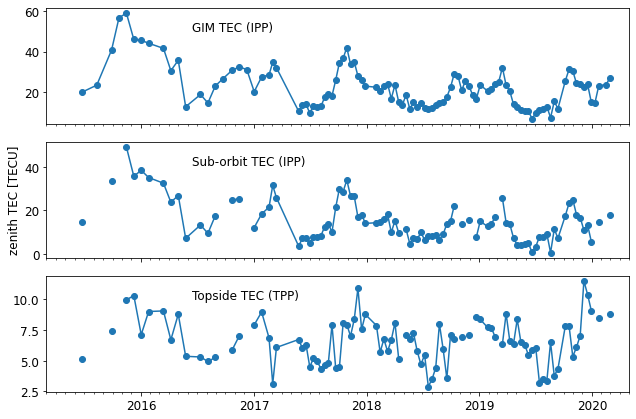

incidence angle on the ground     min/max: 30.0/46.1 deg
incidence angle on the ionosphere min/max: 27.9/42.3 deg


/Users/yunjunz/tools/dev/tools/simulation/iono.py:140: RuntimeWarning: invalid value encountered in sin
  inc_angle_iono = np.arcsin(EARTH_RADIUS * np.sin(inc_angle) / (EARTH_RADIUS + iono_height))


center lat/lon  on the ground    : -21.0438/-68.4108 deg
center lat/lon  on the ionosphere: -21.7329/-71.5353 deg
calculating ionospheric phase ramp time-series from TEC ...
[==================================================] 20200228    0s /     0s 
delete exsited file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/TECjhr.h5
create HDF5 file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/TECjhr.h5 with w mode
create dataset /date        of |S8        in size of (104,)               with compression=None
create dataset /vtec        of float32    in size of (104,)               with compression=None
create dataset /timeseries  of float32    in size of (104, 123, 231)      with compression=None
create dataset /tec_ipp     of float32    in size of (104,)               with compression=None
create dataset /tec_top_tpp of float32    in size of (104,)               with compression=None
create dataset /tec_sub_ipp of float32    in size of (104,)    

/Users/yunjunz/tools/dev/tools/simulation/iono.py:81: RuntimeWarning: invalid value encountered in sin
  ref_angle = np.arcsin(1 / n_iono_group * np.sin(inc_angle * np.pi / 180)) * 180 / np.pi
/Users/yunjunz/tools/dev/tools/simulation/iono.py:59: RuntimeWarning: invalid value encountered in cos
  tec = vtec / np.cos(ref_angle * np.pi / 180.0)


incidence angle on the ground     min/max: 30.0/46.1 deg
incidence angle on the ionosphere min/max: 27.9/42.3 deg
center lat/lon  on the ground    : -21.0438/-68.4108 deg
center lat/lon  on the ionosphere: -21.7329/-71.5353 deg
calculating ionospheric phase ramp time-series from TEC ...
[==================================================] 20200228    0s /     0s 
delete exsited file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/TECsub.h5
create HDF5 file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/TECsub.h5 with w mode
create dataset /date        of |S8        in size of (104,)               with compression=None
create dataset /vtec        of float32    in size of (104,)               with compression=None
create dataset /timeseries  of float32    in size of (104, 123, 231)      with compression=None
create dataset /tec_ipp     of float32    in size of (104,)               with compression=None
create dataset /tec_top_tpp of float32    in 

'/Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/TECjhrRA.h5'

In [9]:
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
ts_file   = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
tec_sub_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECsub.h5')
tec_gim_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhr.h5')

# read GIM/TOP TEC data from Xiaoqing
gim_tec_dir = os.path.join(proj_dir, 'GIM_TEC')
date_list = timeseries(ts_file).get_date_list()
iono_lat, iono_lon = iono.prep_geometry_iono(geom_file, print_msg=True)[1:3]
tec_ipp, tec_top_tpp, tec_sub_ipp, tec_sub_tpp, tDicts = iono.get_sub_tec_list(gim_tec_dir, date_list, iono_lat, iono_lon, interp_method='nearest')[1:]

# read GMT TEC for the missing dates above
gim_tec_file = os.path.join(proj_dir, 'GIM_TEC', 'gimtec.txt')
fc = np.loadtxt(gim_tec_file, dtype=bytes).astype(str)
for i in range(fc.shape[0]):
    ind = date_list.index(fc[i, 0])
    if np.isnan(tec_ipp[ind]):
        tec_ipp[ind] = float(fc[i, 1])

# plot
dates = ptime.date_list2vector(date_list)[0]
ydays = [x.timetuple().tm_yday for x in dates]
titles = ['GIM TEC (IPP)', 'Sub-orbit TEC (IPP)', 'Topside TEC (TPP)']
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 6], sharex=True)
for i, vtec in enumerate([tec_ipp, tec_sub_ipp, tec_top_tpp]):
    axs[i].plot(dates, vtec, 'o-')
    axs[i].annotate(titles[i], xy=(0.25, 0.8), xycoords='axes fraction')
ax = axs[1]
ax.set_ylabel('zenith TEC [TECU]')
pp.auto_adjust_xaxis_date(ax, dates)
fig.tight_layout()
plt.show()

# calc iono ramp time-series
ds_dict_ext = {}
ds_dict_ext['tec_ipp']     = np.array(tec_ipp, dtype=np.float32)
ds_dict_ext['tec_top_tpp'] = np.array(tec_top_tpp, dtype=np.float32)
ds_dict_ext['tec_sub_ipp'] = np.array(tec_sub_ipp, dtype=np.float32)
ds_dict_ext['tec_sub_tpp'] = np.array(tec_sub_tpp, dtype=np.float32)

iono_tec.vtec2iono_ramp_timeseries(date_list, tec_ipp.tolist(),     geom_file=geom_file, iono_file=tec_gim_file, ds_dict_ext=ds_dict_ext)
iono_tec.vtec2iono_ramp_timeseries(date_list, tec_sub_tpp.tolist(), geom_file=geom_file, iono_file=tec_sub_file, ds_dict_ext=ds_dict_ext)
# scaled GIM
tec_gimRF_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhrR69.h5')
tec_gimRA_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhrRA.h5')
iono_tec.vtec2iono_ramp_timeseries(date_list, tec_ipp.tolist(), geom_file=geom_file, iono_file=tec_gimRF_file, ds_dict_ext=ds_dict_ext, sub_tec_ratio='0.69')
iono_tec.vtec2iono_ramp_timeseries(date_list, tec_ipp.tolist(), geom_file=geom_file, iono_file=tec_gimRA_file, ds_dict_ext=ds_dict_ext, sub_tec_ratio='adap')

### Dataset: Chile Sen desc T156

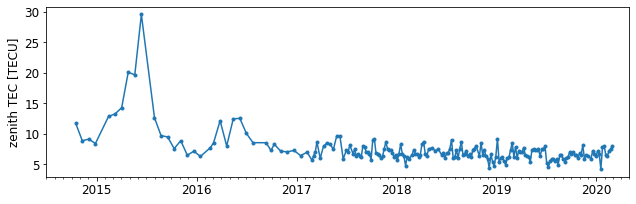

incidence angle on the ground     min/max: 30.8/46.2 deg
incidence angle on the ionosphere min/max: 28.6/42.4 deg


/Users/yunjunz/tools/dev/tools/simulation/iono.py:140: RuntimeWarning: invalid value encountered in sin
  inc_angle_iono = np.arcsin(EARTH_RADIUS * np.sin(inc_angle) / (EARTH_RADIUS + iono_height))


center lat/lon  on the ground    : -21.1462/-68.1329 deg
center lat/lon  on the ionosphere: -21.8427/-64.9786 deg
calculating ionospheric phase ramp time-series from TEC ...
[======================= 80% ===========>          ] 20190628    0s /     0s

/Users/yunjunz/tools/dev/tools/simulation/iono.py:81: RuntimeWarning: invalid value encountered in sin
  ref_angle = np.arcsin(1 / n_iono_group * np.sin(inc_angle * np.pi / 180)) * 180 / np.pi
/Users/yunjunz/tools/dev/tools/simulation/iono.py:59: RuntimeWarning: invalid value encountered in cos
  tec = vtec / np.cos(ref_angle * np.pi / 180.0)


[==================================================] 20200229    0s /     0s 
delete exsited file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/TECjhr.h5
create HDF5 file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/TECjhr.h5 with w mode
create dataset /date       of |S8        in size of (201,)               with compression=None
create dataset /vtec       of float32    in size of (201,)               with compression=None
create dataset /timeseries of float32    in size of (201, 157, 232)      with compression=None
finished writing to /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/TECjhr.h5
incidence angle on the ground     min/max: 30.8/46.2 deg
incidence angle on the ionosphere min/max: 28.6/42.4 deg
center lat/lon  on the ground    : -21.1462/-68.1329 deg
center lat/lon  on the ionosphere: -21.8427/-64.9786 deg
multiply VTEC by 0.69
calculating ionospheric phase ramp time-series from TEC ...
[========================

'/Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/TECjhrRA.h5'

In [10]:
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenDT156')
ts_file   = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
iono_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhr.h5')

# read GIM TEC data from Xiaoqing
gim_tec_file = os.path.join(proj_dir, 'GIM_TEC', 'gimtec_sent1.txt')
fc = np.loadtxt(gim_tec_file, dtype=bytes).astype(str)
date_list = fc[:, 0].tolist()
vtec = fc[:, 1].astype(np.float32)

# plot
x = ptime.date_list2vector(date_list)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 3])
ax.plot(x, vtec, 'o-', ms=3)
ax.set_ylabel('zenith TEC [TECU]')
pp.auto_adjust_xaxis_date(ax, x)
fig.tight_layout()
plt.show()

# calc iono ramp time-series
iono_tec.vtec2iono_ramp_timeseries(date_list, vtec.tolist(), geom_file=geom_file, iono_file=iono_file)
# scaled GIM
tec_gimRF_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhrR69.h5')
tec_gimRA_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhrRA.h5')
iono_tec.vtec2iono_ramp_timeseries(date_list, vtec.tolist(), geom_file=geom_file, iono_file=tec_gimRF_file, ds_dict_ext=ds_dict_ext, sub_tec_ratio='0.69')
iono_tec.vtec2iono_ramp_timeseries(date_list, vtec.tolist(), geom_file=geom_file, iono_file=tec_gimRA_file, ds_dict_ext=ds_dict_ext, sub_tec_ratio='adap')

### Dataset: Kyushu ALOS-2 desc T23

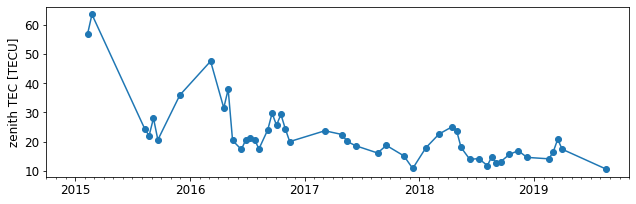

incidence angle on the ground     min/max: 34.2/38.1 deg
incidence angle on the ionosphere min/max: 31.6/35.2 deg
center lat/lon  on the ground    : 32.0694/130.7785 deg
center lat/lon  on the ionosphere: 31.5407/133.9155 deg
calculating ionospheric phase ramp time-series from TEC ...
[==================================================] 20190819    0s /     0s 
delete exsited file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/inputs/TECjhr_v2.h5
create HDF5 file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/inputs/TECjhr_v2.h5 with w mode
create dataset /date       of |S8        in size of (49,)                with compression=None
create dataset /vtec       of float32    in size of (49,)                with compression=None
create dataset /timeseries of float32    in size of (49, 403, 229)       with compression=None
finished writing to /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/inputs/TECjhr_v2.h5
incidence angle on the ground     

'/Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/inputs/TECjhrRA.h5'

In [11]:
proj_dir = os.path.expanduser('~/data/geolocation/KyushuAlos2DT23')
ts_file   = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
iono_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhr_v2.h5')

# read GIM TEC data from Xiaoqing
gim_tec_file = os.path.join(proj_dir, 'GIM_TEC', 'gimtec.txt')
fc = np.loadtxt(gim_tec_file, dtype=bytes).astype(str)
date_list = fc[:, 0].tolist()
vtec = fc[:, 1].astype(np.float32)
#vtec *= 0.69

# plot
x = ptime.date_list2vector(date_list)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 3])
ax.plot(x, vtec, 'o-', ms=6)
ax.set_ylabel('zenith TEC [TECU]')
pp.auto_adjust_xaxis_date(ax, x)
fig.tight_layout()
plt.show()

# calc iono ramp time-series
iono_tec.vtec2iono_ramp_timeseries(date_list, vtec.tolist(), geom_file=geom_file, iono_file=iono_file)
# scaled GIM
tec_gimRF_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhrR69.h5')
tec_gimRA_file = os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhrRA.h5')
iono_tec.vtec2iono_ramp_timeseries(date_list, vtec.tolist(), geom_file=geom_file, iono_file=tec_gimRF_file, ds_dict_ext=ds_dict_ext, sub_tec_ratio='0.69')
iono_tec.vtec2iono_ramp_timeseries(date_list, vtec.tolist(), geom_file=geom_file, iono_file=tec_gimRA_file, ds_dict_ext=ds_dict_ext, sub_tec_ratio='adap')

### Dataset: Salton Sea Sentinel-1 desc T173

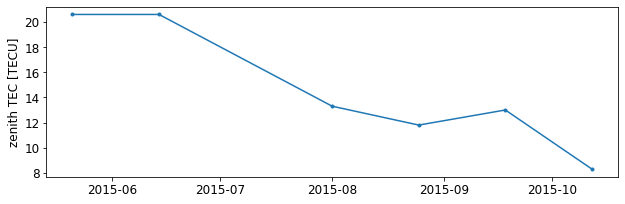

incidence angle on the ground     min/max: 30.7/46.1 deg
incidence angle on the ionosphere min/max: 28.5/42.3 deg
center lat/lon  on the ground    : 33.8499/-115.8618 deg
center lat/lon  on the ionosphere: 33.2657/-112.3090 deg
calculating ionospheric phase ramp time-series from TEC ...
[==================================================] 20151012    0s /     0s 
delete exsited file: /Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v2/inputs/gimTEC.h5
create HDF5 file: /Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v2/inputs/gimTEC.h5 with w mode
create dataset /date       of |S8        in size of (6,)                 with compression=None
create dataset /vtec       of float32    in size of (6,)                 with compression=None
create dataset /timeseries of float32    in size of (6, 792, 677)        with compression=None
finished writing to /Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v2/inputs/gimTEC.h5


'/Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v2/inputs/gimTEC.h5'

In [5]:
proj_dir = os.path.expanduser('~/data/offset4motion/SaltonSeaSenDT173')
ts_file   = os.path.join(proj_dir, 'mintpy_offset_v2/timeseriesRg.h5')
geom_file = os.path.join(proj_dir, 'mintpy_offset_v2/inputs/geometryRadar.h5')
iono_file = os.path.join(proj_dir, 'mintpy_offset_v2/inputs/TECjhr.h5')

# read GIM TEC data from Xiaoqing
gim_tec_file = os.path.join(proj_dir, 'GIM_TEC', 'gimtec.txt')
fc = np.loadtxt(gim_tec_file, dtype=bytes).astype(str)
date_list = fc[:, 0].tolist()
vtec_list = fc[:, 1].astype(np.float32).tolist()

# plot
x = ptime.date_list2vector(date_list)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 3])
ax.plot(x, vtec_list, 'o-', ms=3)
ax.set_ylabel('zenith TEC [TECU]')
#pp.auto_adjust_xaxis_date(ax, x)
fig.tight_layout()
plt.show()

# calc iono ramp time-series
iono_tec.vtec2iono_ramp_timeseries(date_list, vtec_list, geom_file=geom_file, iono_file=iono_file)

## Backups - SUB TEC for Chile asc track 149

### 1. latitude distance between TEC TPP and SAR

min/max distance : 0.0/3.0 deg
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/topTEC_latDist.png


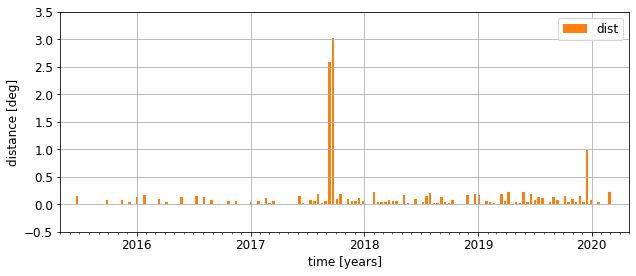

In [22]:
flag = np.array([i is not None for i in tDicts], dtype=np.bool_)
date_list = np.array(date_list)[flag].tolist()
dates = ptime.date_list2vector(date_list)[0]
tDicts = [i for i in tDicts if i is not None]

# calc nearest TOP TEC in latitude only
num_date = len(date_list)
lat_dist = np.zeros(num_date, dtype=np.float32)
for i in range(num_date):
    lats = tDicts[i]['lat']
    lat_dist[i] = np.min(np.abs(lats - iono_lat))
print('min/max distance : {:.1f}/{:.1f} deg'.format(np.min(lat_dist), np.max(lat_dist)))

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.bar(dates, lat_dist, width=8, color='C1', label='dist')
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.5, 3.5)
ax.set_xlabel('time [years]')
ax.set_ylabel('distance [deg]')
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
ax.grid('on')

ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(proj_dir, 'mintpy_offset/inputs/topTEC_latDist.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 2. location between TEC TPP and SAR

[==================================================] 20200228    0s /     0s 
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/topTEC_loc.png


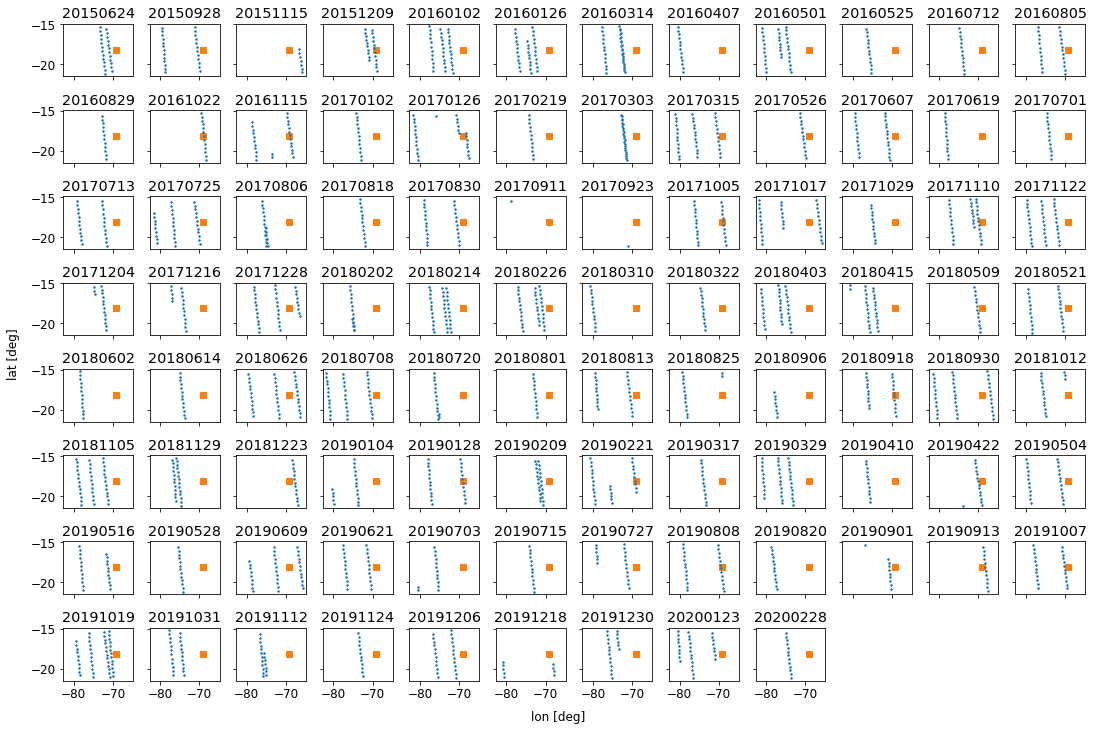

In [24]:
fig, axs = plt.subplots(figsize=[15, 10], nrows=8, ncols=12, sharex=True, sharey=True)
prog_bar = ptime.progressBar(maxValue=num_date)
for i in range(num_date):
    ax = axs.flatten()[i]
    lats = tDicts[i]['lat']
    lons = tDicts[i]['lon']

    # plot
    ax.plot(iono_lon, iono_lat, 's', color='C1', label='TGT')                   # SAR
    ax.plot(lons,     lats,     '.', color='C0', label='TPP', ms=3)             # TPP
    ax.set_title(date_list[i])

    prog_bar.update(i+1, suffix=date_list[i])
prog_bar.close()

for i in range(num_date, axs.size):
    axs.flatten()[i].set_visible(False)

# axis format
fig.text(0.5, -0.01, 'lon [deg]', ha='center')
fig.text(-0.01, 0.5, 'lat [deg]', va='center', rotation='vertical')
fig.tight_layout()

# output
out_fig = os.path.join(proj_dir, 'mintpy_offset/inputs/topTEC_loc.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3. Impact of interpolation method for TOPTEC

TOP TEC from **nearest lat/lon** gives the smallest final residual (SAR - subTEC - ERA5 - SET).

In [19]:
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
ts_file = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg_S1Bias.h5')
tec_files = [
    os.path.join(proj_dir, 'mintpy_offset/inputs/TECsubMean.h5'),
    os.path.join(proj_dir, 'mintpy_offset/inputs/TECsubMed.h5'),
    os.path.join(proj_dir, 'mintpy_offset/inputs/TECsubNearLat.h5'),
    os.path.join(proj_dir, 'mintpy_offset/inputs/TECsubNearLatLon.h5'),
]
set_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/SET.h5')
era5_file = os.path.join(proj_dir, 'mintpy_offset/inputs/ERA5.h5')

geom_file = os.path.join(proj_dir, 'mintpy_offset', 'inputs/geometryRadar.h5')
mask_file = os.path.join(proj_dir, 'mintpy_offset', 'maskResInv.h5')

# date info
date_list = timeseries(ts_file).get_date_list()
num_date = len(date_list)

# Point of interest
lalo = [-21.30, -67.39]
atr = readfile.read_attribute(ts_file)
coord = ut.coordinate(atr, lookup_file=geom_file)
y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
win = 10
box = (x-win, y-win, x+win+1, y+win+1)

# read data
mask = readfile.read(mask_file, box=box)[0].flatten()
for tec_file in tec_files:
    ts_data  = readfile.read(ts_file,   box=box)[0].reshape(num_date, -1)[:, mask]
    ts_data += readfile.read(tec_file,  box=box)[0].reshape(num_date, -1)[:, mask]
    ts_data -= readfile.read(set_file,  box=box)[0].reshape(num_date, -1)[:, mask]
    ts_data -= readfile.read(era5_file, box=box)[0].reshape(num_date, -1)[:, mask]
    ts_med = np.nanmedian(ts_data, axis=-1)
    ts_med -= np.nanmedian(ts_med)

    # print out stats
    rmse = ut.root_mean_sq_error(ts_med) * 100
    print('Final RMSE w TEC = {:<20}: {:.2f} cm'.format(os.path.basename(tec_file), rmse))

Final RMSE w TEC = TECsubMean.h5       : 5.47 cm
Final RMSE w TEC = TECsubMed.h5        : 5.50 cm
Final RMSE w TEC = TECsubNearLat.h5    : 5.50 cm
Final RMSE w TEC = TECsubNearLatLon.h5 : 5.10 cm


### 4. GIM TEC vs. GIM TEC

IGS TEC can be pretty bad sometimes!

tsview.py /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/igsTEC.h5 /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/gimTEC.h5 --lalo -21.0 -68.4 --lookup /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/geometryRadar.h5 --noverbose --figsize 9 4


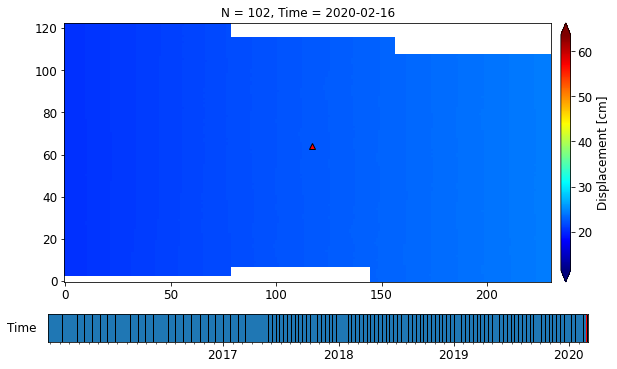

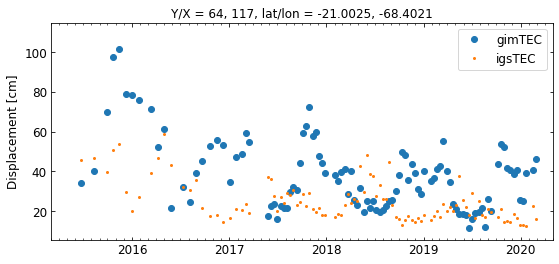

tsview.py /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/igsTEC.h5 /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/gimTEC.h5 --lalo -21.0 -68.4 --lookup /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/geometryRadar.h5 --noverbose --figsize 9 4


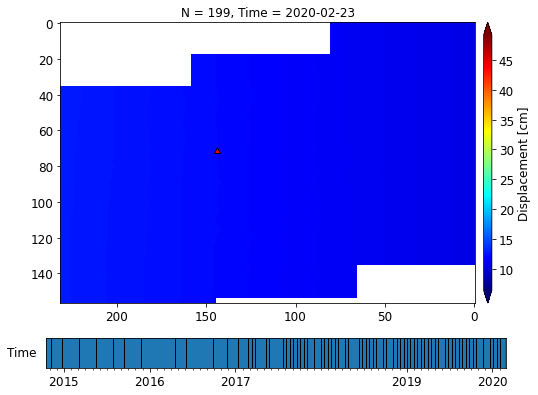

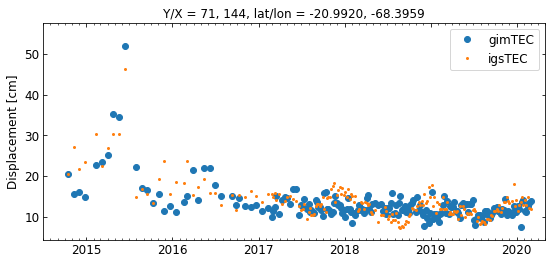

In [12]:
from mintpy import tsview
proj_dirs = [os.path.expanduser('~/data/geolocation/ChileSenAT149'),
             os.path.expanduser('~/data/geolocation/ChileSenDT156')]
for proj_dir in proj_dirs:
    gim_tec_file = os.path.join(proj_dir, 'mintpy_offset/inputs/gimTEC.h5')
    igs_tec_file = os.path.join(proj_dir, 'mintpy_offset/inputs/igsTEC.h5')
    geom_file    = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
    iargs = [igs_tec_file, gim_tec_file, '--lalo', '-21.0', '-68.4', '--lookup', geom_file, '--noverbose', '--figsize', '9', '4']
    tsview.main(iargs)